In [1]:
from polygon import RESTClient
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
client = RESTClient("Lmxh45Sd1XptLOy_KKAATu9nE2oQ_5tp")

In [3]:
aggs = []
for a in client.list_aggs(
    "AAPL",
    1,
    "day",
    "2022-10-27",
    "2023-10-28",
    limit=50000,
):
    aggs.append(a)

print(len(aggs))

252


In [4]:
stock_df = pd.DataFrame(aggs)
stock_df['timestamp'] = pd.to_datetime(stock_df['timestamp'],unit='ms')
stock_df['timestamp'] = stock_df['timestamp'].astype('datetime64[ms]')
stock_df.rename(columns={'timestamp':'datetime'},inplace=True)
dataframe = stock_df.set_index("datetime", verify_integrity=True)
dataframe

,open,high,low,close,volume,vwap,transactions,otc
datetime,,,,,,,,
2022-10-27 04:00:00,148.070,149.0460,144.13,144.80,109161970.0,145.3119,944053,None
2022-10-28 04:00:00,148.200,157.5000,147.82,155.74,164762371.0,154.5822,1228075,None
2022-10-31 04:00:00,153.155,154.2400,151.92,153.34,97932271.0,153.2791,726843,None
2022-11-01 04:00:00,155.080,155.4500,149.13,150.65,80379345.0,150.9807,650595,None
2022-11-02 04:00:00,148.945,152.1700,145.00,145.03,93604623.0,148.2186,788400,None
...,...,...,...,...,...,...,...,...
2023-10-23 04:00:00,170.910,174.0100,169.93,173.00,55980109.0,172.3829,639616,None
2023-10-24 04:00:00,173.050,173.6700,171.45,173.44,43816644.0,172.7333,530406,None
2023-10-25 04:00:00,171.880,173.0600,170.65,171.10,57156962.0,171.4932,610143,None


In [5]:
stock_df.rename(columns={'timestamp':'datetime'},inplace=True)

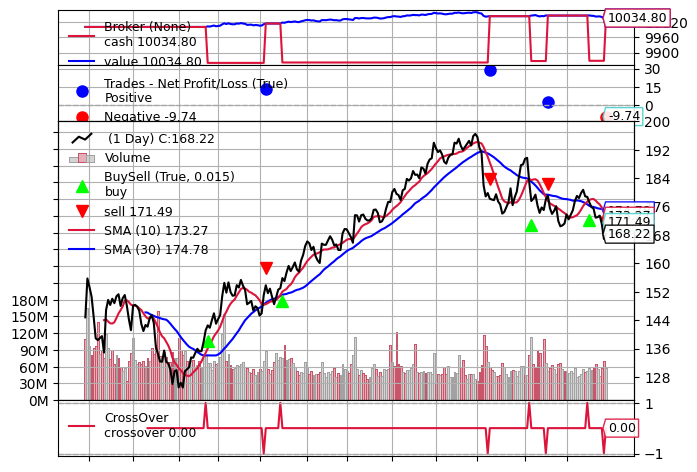

[[<Figure size 640x480 with 5 Axes>]]

In [6]:
import backtrader as bt

# Create a subclass of Strategy to define the indicators and logic

class SmaCross(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=30   # period for the slow moving average
    )

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal

    def next(self):
        if not self.position:  # not in the market
            if self.crossover > 0:  # if fast crosses slow to the upside
                self.buy()  # enter long

        elif self.crossover < 0:  # in the market & cross to the downside
            self.close()  # close long position


cerebro = bt.Cerebro()  # create a "Cerebro" engine instance

# Create a data feed
# data = bt.feeds.YahooFinanceData(dataname='MSFT',
#                                  fromdate=datetime(2023, 10, 1),
#                                  todate=datetime(2023, 10, 31))

data = bt.feeds.PandasData(dataname=dataframe)

cerebro.adddata(data)  # Add the data feed

cerebro.addstrategy(SmaCross)  # Add the trading strategy
cerebro.run()  # run it all
cerebro.plot(iplot=False)  # and plot it with a single command